In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Literal, Union
import ee
import geemap
from shapely.geometry import Point
from validate_dowscaled_et import create_ee_feature_collection
import calendar
from datetime import datetime

In [2]:
ee.Initialize(project="thurgau-irrigation")

# 1: Rietholzbach

## Cleaning and aggregating the hourly ET data to daily data for Rietholzbach.

The aggregation is based on the following:

1. Sum Available Hourly Data:
   - For each day, sum all the available hourly evapotranspiration (ET) measurements to obtain a partial daily total.

2. Count Available Hours:
   - Count the number of hours with available data for each day (denoted as *n*).

3. Calculate Average Hourly ET:
   - Compute the average hourly ET for the day:
     $$
     \text{Average Hourly ET} = \frac{\text{Partial Daily Total}}{n}
     $$

4. Estimate Total Daily ET:
   - Estimate the total daily ET by scaling the average hourly ET to 24 hours:
     $$
     \text{Estimated Daily Total ET} = \text{Average Hourly ET} \times 24 = \text{Partial Daily Total} \times \left( \frac{24}{n} \right)
     $$

5. Handle Missing Data:
   - If any hours are missing within a day, this method adjusts the daily total by assuming that the missing hours have similar ET rates to the average of the available hours.
   - If all data is missing for a day, the daily total is set to `NaN`.




In [3]:
# WARNING: These two functions could be merged into one but I am a little to lazy to do it now

def read_and_process_etl_hourly_data(
    data_folder: str, file_start: str, year_range: List[int]
) -> pd.Series:
    """
    Read, clean, and aggregate ETL data from multiple files.

    Args:
        data_folder (str): Path to the folder containing ETL data files.
        file_start (str): Common prefix of the ETL data files.
        year_range (List[int]): List of years to process.

    Returns:
        pd.Series: Daily aggregated evapotranspiration data.
    """
    all_data = []

    for year in year_range:
        filename = os.path.join(data_folder, f"{file_start}{year}.txt")
        df = pd.read_csv(
            filename,
            sep=";",
            skiprows=26,
            header=None,
            names=["datetime", "evapotranspiration", "flag"],
            dtype={"datetime": str, "evapotranspiration": float, "flag": int},
        )

        # Process datetime column
        df["datetime"] = df["datetime"].str.replace("24:00", "00:00")
        df["datetime"] = pd.to_datetime(df["datetime"], format="%d-%m-%Y %H:%M")
        df["datetime"] += pd.to_timedelta(
            (df["datetime"].dt.hour == 0).astype(int), unit="D"
        )

        df.set_index("datetime", inplace=True)
        all_data.append(df)

    combined_df = pd.concat(all_data)

    # Clean data
    cleaned_df = combined_df[
        (combined_df["flag"] != 1) & (combined_df["evapotranspiration"] != -9999)
    ]["evapotranspiration"]

    # Aggregate to daily
    daily_et = cleaned_df.resample("D").apply(
        lambda x: x.sum() * (24 / x.count()) if x.count() > 0 else np.nan
    )

    daily_et = daily_et.dropna()

    return daily_et


def read_and_process_etl_daily_data(
    data_folder: str,
    file_start: str,
    year_range: List[int],
) -> pd.Series:
    """
    Read, clean, and optionally aggregate ETL data from multiple files.

    Args:
        data_folder (str): Path to the folder containing ETL data files.
        file_start (str): Common prefix of the ETL data files.
        year_range (List[int]): List of years to process.

    Returns:
        pd.Series: Daily evapotranspiration data.
    """
    all_data = []

    for year in year_range:
        filename = os.path.join(data_folder, f"{file_start}{year}.txt")
        df = pd.read_csv(
            filename,
            sep=";",
            skiprows=34,
            header=None,
            names=["datetime", "evapotranspiration", "flag"],
            dtype={"datetime": str, "evapotranspiration": float, "flag": int},
        )

        # Process datetime column
        df["datetime"] = pd.to_datetime(df["datetime"], format="%d-%m-%Y")

        df.set_index("datetime", inplace=True)
        all_data.append(df)

    combined_df = pd.concat(all_data)

    # Clean data
    cleaned_df = combined_df[
        (combined_df["flag"] != 1) & (combined_df["evapotranspiration"] != -9999)
    ]["evapotranspiration"]

    daily_et = cleaned_df

    return daily_et

In [4]:
# data_folder = "/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /RietholzbachData_Hirschi_etal_HESS/hourly/Evapotranspiration"
# file_start = "ETL_"
# year_range = range(2009, 2016)

# hourly_ET_aggregated = read_and_process_etl_hourly_data(data_folder, file_start, year_range, frequency="H")

data_folder = "/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /ETL1"
file_start = "ETL1_"
year_range = range(2017, 2022)

daily_ET = read_and_process_etl_daily_data(data_folder, file_start, year_range)

In [5]:
daily_ET

datetime
2017-01-01    0.482
2017-01-02    0.000
2017-01-03    0.450
2017-01-04    0.000
2017-01-05    0.000
              ...  
2021-12-27    0.000
2021-12-28    0.000
2021-12-29    0.000
2021-12-30    0.000
2021-12-31    0.000
Name: evapotranspiration, Length: 1714, dtype: float64

## Exporting the time series to an ee.FeatureCollection

In [6]:
station_x = 8.998613
station_y = 47.3800787405

# fc_hourly_agg = create_ee_feature_collection(hourly_ET_aggregated, station_x, station_y)
daily_ET = create_ee_feature_collection(daily_ET, station_x, station_y)

In [7]:
daily_ET.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [8.998613, 47.3800787405]},
 'id': '0',
 'properties': {'date_[YYYYmmdd]': '2017-01-01',
  'evapotranspiration_[mm/d]': 0.482,
  'system:time_start': 1483228800000}}

In [8]:
# # Export the FeatureCollection to an Earth Engine asset
# task = ee.batch.Export.table.toAsset(
#     collection=fc_hourly_agg,
#     description="evapotranspiration_timeseries_rietholzbach",
#     assetId="projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2009_2015",
# )
# task.start()

# Export the FeatureCollection to an Earth Engine asset
task = ee.batch.Export.table.toAsset(
    collection=daily_ET,
    description="evapotranspiration_timeseries_rietholzbach_extended",
    assetId="projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2017_2021",
)
task.start()

## Checking that the export ran successfully

In [9]:
point_fc = ee.FeatureCollection(
    "projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2017_2021"
).sort("system:time_start")

# Print the first feature to verify
ee.Date(point_fc.first().get("system:time_start")).format("YYYY-MM-dd").getInfo()

'2017-01-01'

# 2: Oensingen

### **Warning**: this code is not very clean. There is a lot of code duplication. The only use for this code is to export the ET validation data to an ee.FeatureCollection. It will not be used for further analysis.

## Evapotranspiration Calculation

The monthly evapotranspiration (ET) is calculated using the following equation:

$ET_{mm/month} = \frac{LE}{\lambda \cdot \rho} \cdot 86400 \cdot 1000 \cdot days_{month}$

Where:
- $ET_{mm/month}$ is the evapotranspiration in mm/month
- $LE$ is the latent energy flux in W/m²
- $\lambda$ is the latent heat of vaporization in J/kg, calculated as:
  $\lambda = 2.501 \times 10^6 - 2361 \cdot T_{air}$
- $\rho$ is the density of water (1000 kg/m³)
- $T_{air}$ is the air temperature in °C
- $86400$ is the number of seconds in a day
- $1000$ is the conversion factor from m to mm
- $days_{month}$ is the number of days in the month

The calculation steps are as follows:

1. Calculate $\lambda$ using air temperature
2. Convert LE to ET in kg/m²/s: $ET_{kg/m²/s} = \frac{LE}{\lambda \cdot \rho}$
3. Convert to mm/day: $ET_{mm/day} = ET_{kg/m²/s} \cdot 86400 \cdot 1000$
4. Convert to mm/month: $ET_{mm/month} = ET_{mm/day} \cdot days_{month}$

This equation accounts for the temperature-dependent latent heat of vaporization and converts the energy flux to a monthly water depth equivalent.

In [5]:
file_path = "/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /Oensingen_Flux_Net.csv"
oensingen = pd.read_csv(file_path, sep=",", decimal=".", parse_dates=["TIMESTAMP"])

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_90826/3571855329.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oensingen = pd.read_csv(file_path, sep=",", decimal=".", parse_dates=["TIMESTAMP"])


In [6]:
oensingen.tail()

,TIMESTAMP,TA_F_MDS,TA_F_MDS_QC,TA_F_MDS_NIGHT,TA_F_MDS_NIGHT_SD,TA_F_MDS_NIGHT_QC,TA_F_MDS_DAY,TA_F_MDS_DAY_SD,TA_F_MDS_DAY_QC,TA_ERA,...,GPP_DT_CUT_SE,GPP_DT_CUT_05,GPP_DT_CUT_16,GPP_DT_CUT_25,GPP_DT_CUT_50,GPP_DT_CUT_75,GPP_DT_CUT_84,GPP_DT_CUT_95,RECO_SR,RECO_SR_N
199,202008,19.609,1.000000,16.718,2.117,1.000000,21.478,3.577,1.0,-9999.0,...,0.026377,0.673065,0.805153,0.871584,0.945161,1.06339,1.15471,1.25898,-9999,-9999
200,202009,15.886,1.000000,13.391,2.136,1.000000,17.987,3.339,1.0,-9999.0,...,0.009081,2.593930,2.660010,2.674970,2.720840,2.76126,2.77251,2.81129,-9999,-9999
201,202010,9.138,1.000000,8.143,1.421,1.000000,10.285,1.993,1.0,-9999.0,...,0.021746,5.026180,5.102330,5.125710,5.202930,5.29768,5.34175,5.39308,-9999,-9999
202,202011,5.090,0.720139,4.348,1.098,0.733333,6.198,1.511,0.7,-9999.0,...,0.045169,3.190370,3.344690,3.376200,3.530380,3.71557,3.88394,3.94379,-9999,-9999
203,202012,2.425,1.000000,2.108,0.905,1.000000,2.951,0.877,1.0,-9999.0,...,0.017595,1.947130,2.052850,2.067600,2.152660,2.20522,2.23356,2.33858,-9999,-9999


In [11]:
def calc_et_from_le_mm_month(LE, Tair, days_in_month):
    """
    Calculate evapotranspiration (ET) from latent energy (LE) and air temperature (Tair),
    and convert it to mm/month.
    
    Args:
        LE (float or array-like): Latent energy flux (W/m^2)
        Tair (float or array-like): Air temperature (°C)
        days_in_month (int): Number of days in the current month
    
    Returns:
        ET_mm_month (float or array-like): Evapotranspiration in mm/month
    """
    # Constants
    rho = 1000  # Density of water in kg/m^3
    lambda_T = 2.501e6 - 2361 * Tair  # Latent heat of vaporization (J/kg), temperature dependent
    seconds_per_day = 86400  # Number of seconds in a day
    
    # Calculate ET in kg/m^2/s
    ET_kg_m2_s = LE / (lambda_T * rho)
    
    # Convert ET to mm/day
    ET_mm_day = ET_kg_m2_s * seconds_per_day * 1000  # Convert to mm/day (1 kg/m^2 = 1 mm)
    
    # Convert to mm/month
    ET_mm_month = ET_mm_day * days_in_month
    
    return ET_mm_month

def get_days_in_month(timestamp):
    """
    Get the number of days in a month based on the timestamp.
    
    Args:
        timestamp (str): Timestamp in the format 'YYYYMM'
    
    Returns:
        int: Number of days in the month
    """
    year = int(timestamp[:4])
    month = int(timestamp[4:])
    return calendar.monthrange(year, month)[1]

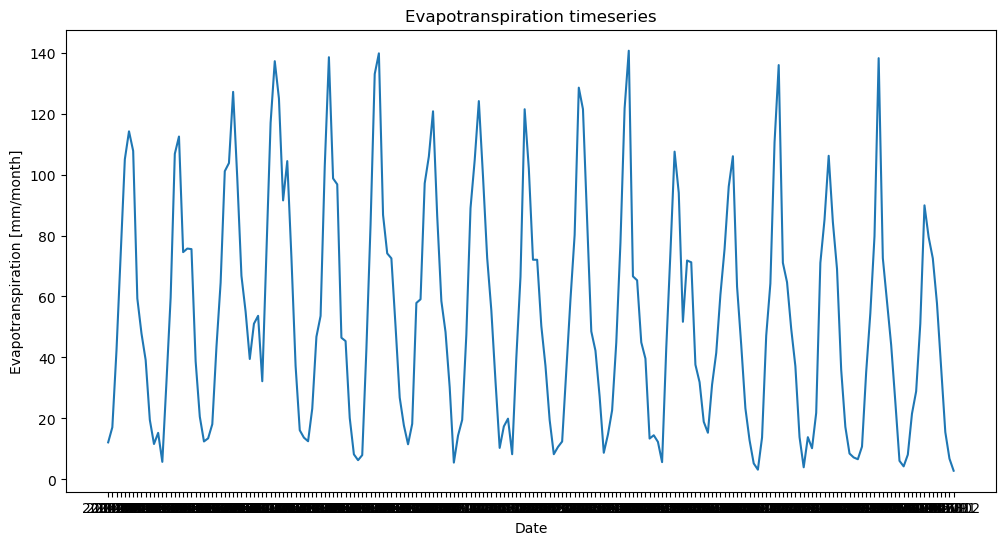

In [23]:
# Assuming your dataframe is named 'oensingen'
# Create a new column for the number of days in each month
oensingen['days_in_month'] = oensingen['TIMESTAMP'].astype(str).apply(get_days_in_month)

# Calculate ET_[mm/month] using the calc_et_from_le_mm_month function
oensingen['ET_[mm/month]'] = calc_et_from_le_mm_month(
    oensingen['LE_F_MDS'],
    oensingen['TA_F_MDS'],
    oensingen['days_in_month']
)

oensingen[['TIMESTAMP', 'LE_F_MDS', 'TA_F_MDS', 'days_in_month', 'ET_[mm/month]']]

In [14]:
# Define the coordinate (already in EPSG:4326)
STATION_LAT = 47.286417
STATION_LON = 7.733750

def pandas_dataframe_to_ee_features(df: pd.DataFrame) -> List[ee.Feature]:
    """
    Convert a pandas DataFrame to a list of Earth Engine Features.

    Args:
        df (pd.DataFrame): Input pandas DataFrame with TIMESTAMP and ET_[mm/month] columns.

    Returns:
        List[ee.Feature]: List of Earth Engine Features.
    """
    features = []
    for _, row in df.iterrows():
        timestamp = str(row['TIMESTAMP'])
        year = int(timestamp[:4])
        month = int(timestamp[4:6])
        date = f"{year}-{month:02d}-01"  # Convert YYYYMM to YYYY-MM-01
        feature = ee.Feature(
            ee.Geometry.Point([STATION_LON, STATION_LAT]),
            {
                "date_[YYYYmmdd]": date,
                "evapotranspiration_[mm/month]": float(row['ET_[mm/month]']),
                "system:time_start": ee.Date(date).millis(),
            },
        )
        features.append(feature)
    return features

def create_ee_feature_collection(df: pd.DataFrame) -> ee.FeatureCollection:
    """
    Create an Earth Engine FeatureCollection from a pandas DataFrame.

    Args:
        df (pd.DataFrame): Input pandas DataFrame with TIMESTAMP and ET_[mm/month] columns.

    Returns:
        ee.FeatureCollection: Earth Engine FeatureCollection containing the time series data.
    """
    features = pandas_dataframe_to_ee_features(df)
    return ee.FeatureCollection(features).sort("system:time_start")

In [16]:
fc = create_ee_feature_collection(oensingen)
fc.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [7.73375, 47.286417]},
 'id': '0',
 'properties': {'date_[YYYYmmdd]': '2004-01-01',
  'evapotranspiration_[mm/month]': 12.173487436520707,
  'system:time_start': 1072915200000}}

In [18]:
# Export the FeatureCollection to an Earth Engine asset
task = ee.batch.Export.table.toAsset(
    collection=fc,
    description="evapotranspiration_timeseries_oesingen",
    assetId="projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_oensingen_2004_2020",
)
task.start()

In [20]:
point_fc = ee.FeatureCollection(
    "projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_oensingen_2004_2020"
).sort("system:time_start")

# Print the first feature to verify
point_fc.size().getInfo()

204